In [1]:
import numpy as np
import pandas as pd

In [2]:
mamm_csv = "mamografias.csv"

In [3]:
missing_values_format = ["?"]
mamm_data = pd.read_csv(mamm_csv, na_values=missing_values_format)
mamm_data.head()

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,L,5.0,3.0,maligno
1,4.0,43.0,R,1.0,NaN,maligno
2,5.0,58.0,I,5.0,3.0,maligno
3,4.0,28.0,R,1.0,3.0,benigno
4,5.0,74.0,R,5.0,NaN,maligno


In [4]:
mamm_data_without_nan = mamm_data.dropna()

In [5]:
cols = [col for col in mamm_data.columns if col not in ['Severity']]

In [6]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler

le = LabelEncoder()
#convert the categorical columns into numeric
mamm_data['Severity'] = le.fit_transform(mamm_data['Severity'])
mamm_data['Shape'] = le.fit_transform(mamm_data['Shape'])

In [7]:
#convert the categorical columns into numeric
mamm_data_without_nan['Severity'] = le.fit_transform(mamm_data_without_nan['Severity'])
mamm_data_without_nan['Shape'] = le.fit_transform(mamm_data_without_nan['Shape'])

In [8]:
X_no_nan = mamm_data_without_nan[cols]
y_no_nan= mamm_data_without_nan['Severity']
X = mamm_data[cols]
y = mamm_data['Severity']

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_no_nan_scaled = scaler.fit_transform(X_no_nan)

In [10]:
min_max = MinMaxScaler()
X_min_max = min_max.fit_transform(X)
X_no_nan_min_max = min_max.fit_transform(X_no_nan)

In [11]:
from sklearn.model_selection import cross_val_score

def get_full_score(regressor, X_full, y_full):
    full_scores = cross_val_score(regressor, X_full, y_full, scoring='accuracy', cv=N_SPLITS)
    return full_scores.mean(), full_scores.std()

def get_full_score_roc_auc(regressor, X_full, y_full):
    full_scores = cross_val_score(regressor, X_full, y_full, scoring='roc_auc', cv=N_SPLITS)
    return full_scores.mean(), full_scores.std()


N_SPLITS = 5

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [13]:
categorical_features = ['Shape']
categorical_transformer = Pipeline(
    [
        ('imputer_cat', SimpleImputer()),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

numeric_features = ['BI-RADS','Age', 'Margin', 'Density']
numeric_transformer = Pipeline(
    [
        ('imputer_num', SimpleImputer()),
        ('scaler', StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    [
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ]
)

# LogisticRegression

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [16]:
pipeline = Pipeline(
    [
        ('pre', preprocessor),
        ('clf', LogisticRegression())
    ]
)

In [17]:
get_full_score(pipeline, X, y)

(0.8303972366148532, 0.03196710575271904)

In [18]:
get_full_score_roc_auc(pipeline, X, y)

(0.8928297362613387, 0.03020374515009528)

In [19]:
lr = LogisticRegression()
get_full_score(lr , X_no_nan, y_no_nan)

(0.8193456317438217, 0.01827861830377375)

In [20]:
get_full_score_roc_auc(LogisticRegression(), X_no_nan, y_no_nan)

(0.9007075591915793, 0.024963986706225794)

In [21]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pre', 'clf', 'pre__n_jobs', 'pre__remainder', 'pre__sparse_threshold', 'pre__transformer_weights', 'pre__transformers', 'pre__verbose', 'pre__cat', 'pre__num', 'pre__cat__memory', 'pre__cat__steps', 'pre__cat__verbose', 'pre__cat__imputer_cat', 'pre__cat__onehot', 'pre__cat__imputer_cat__add_indicator', 'pre__cat__imputer_cat__copy', 'pre__cat__imputer_cat__fill_value', 'pre__cat__imputer_cat__missing_values', 'pre__cat__imputer_cat__strategy', 'pre__cat__imputer_cat__verbose', 'pre__cat__onehot__categories', 'pre__cat__onehot__drop', 'pre__cat__onehot__dtype', 'pre__cat__onehot__handle_unknown', 'pre__cat__onehot__sparse', 'pre__num__memory', 'pre__num__steps', 'pre__num__verbose', 'pre__num__imputer_num', 'pre__num__scaler', 'pre__num__imputer_num__add_indicator', 'pre__num__imputer_num__copy', 'pre__num__imputer_num__fill_value', 'pre__num__imputer_num__missing_values', 'pre__num__imputer_num__strategy', 'pre__num__imputer_num__verbose', 'pr

In [22]:
params_lr = [
    {
        'clf': [LogisticRegression(random_state=10)],   
        'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'clf__penalty': ['none', 'l1', 'l2', 'elasticnet'],
        'clf__C': [0.01, 0.1, 1, 10, 100],
        'pre__cat__imputer_cat__strategy': ['most_frequent', 'median'],
        'pre__num__imputer_num__strategy': ['mean', 'median']
    }
]

In [23]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=10)

print("# Tuning hyper-parameters for accuracy")
print()

clf = GridSearchCV(pipeline, params_lr, scoring='accuracy', cv=N_SPLITS, refit = True)
clf.fit(X_train, y_train)
print("Best mean cross-validation score: {:.3f}".format(clf.best_score_))
print("Best parameters:", clf.best_params_)
print("test-set score: {:.3f}".format(clf.score(X_test, y_test)))


# Tuning hyper-parameters for accuracy

Best mean cross-validation score: 0.842
Best parameters: {'clf': LogisticRegression(C=0.01, random_state=10, solver='newton-cg'), 'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg', 'pre__cat__imputer_cat__strategy': 'most_frequent', 'pre__num__imputer_num__strategy': 'mean'}
test-set score: 0.827


In [24]:
# utilizando el mejor modelo
best_lr = clf.best_estimator_
print("Best estimator:", best_lr)
get_full_score(best_lr, X, y)

Best estimator: Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Shape']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['BI-RADS', 'Age', 'Marg

(0.8335276338514681, 0.032319847105984616)

In [25]:
get_full_score_roc_auc(best_lr, X, y)

(0.8933944709702863, 0.029281713125189245)

## Tabla combinaciones Logistic Regression

In [26]:
df_report = pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
df_report = df_report.sort_values(by=['Accuracy'], ascending=False)
df_report = df_report.dropna()
df_report =df_report.drop(['clf'], axis=1)
df_report.head(10)

,clf__C,clf__penalty,clf__solver,pre__cat__imputer_cat__strategy,pre__num__imputer_num__strategy,Accuracy
43,0.01,l2,newton-cg,median,median,0.841667
55,0.01,l2,sag,median,median,0.841667
53,0.01,l2,sag,most_frequent,median,0.841667
52,0.01,l2,sag,most_frequent,mean,0.841667
56,0.01,l2,saga,most_frequent,mean,0.841667
57,0.01,l2,saga,most_frequent,median,0.841667
58,0.01,l2,saga,median,mean,0.841667
59,0.01,l2,saga,median,median,0.841667
47,0.01,l2,lbfgs,median,median,0.841667
46,0.01,l2,lbfgs,median,mean,0.841667


In [27]:
# export to latex
print(df_report.to_latex(index=False))

\begin{tabular}{rllllr}
\toprule
 clf\_\_C & clf\_\_penalty & clf\_\_solver & pre\_\_cat\_\_imputer\_cat\_\_strategy & pre\_\_num\_\_imputer\_num\_\_strategy &  Accuracy \\
\midrule
   0.01 &           l2 &   newton-cg &                          median &                          median &  0.841667 \\
   0.01 &           l2 &         sag &                          median &                          median &  0.841667 \\
   0.01 &           l2 &         sag &                   most\_frequent &                          median &  0.841667 \\
   0.01 &           l2 &         sag &                   most\_frequent &                            mean &  0.841667 \\
   0.01 &           l2 &        saga &                   most\_frequent &                            mean &  0.841667 \\
   0.01 &           l2 &        saga &                   most\_frequent &                          median &  0.841667 \\
   0.01 &           l2 &        saga &                          median &                      

In [28]:
categorical_features = ['Shape']
categorical_transformer_lr = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

numeric_features = ['BI-RADS','Age', 'Margin', 'Density']
numeric_transformer_lr = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

preprocessor_lr = ColumnTransformer(
    [
        ('cat', categorical_transformer_lr, categorical_features),
        ('num', numeric_transformer_lr, numeric_features)
    ]
)

In [29]:
C_param_range = [0.01, 0.1, 1,10, 100]
lr_newton_scores, lr_lbfgs_scores, lr_liblinear_scores = [], [], []

for i in C_param_range:
    lr_newton = Pipeline(steps=[('pre', preprocessor_lr), ('classifier', LogisticRegression(C = i, solver='newton-cg', penalty = 'l2'))])
    lr_lbfgs = Pipeline(steps=[('pre', preprocessor_lr), ('classifier', LogisticRegression(C = i, solver='lbfgs', penalty = 'l2'))])
    lr_liblinear = Pipeline(steps=[('pre', preprocessor_lr), ('classifier', LogisticRegression(C = i, solver='liblinear', penalty = 'l1'))])
    lr_newton_scores.append(get_full_score(lr_newton, X, y)[0])
    lr_lbfgs_scores.append(get_full_score(lr_lbfgs, X, y)[0])
    lr_liblinear_scores.append(get_full_score(lr_liblinear, X, y)[0])

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

## Gráfica 

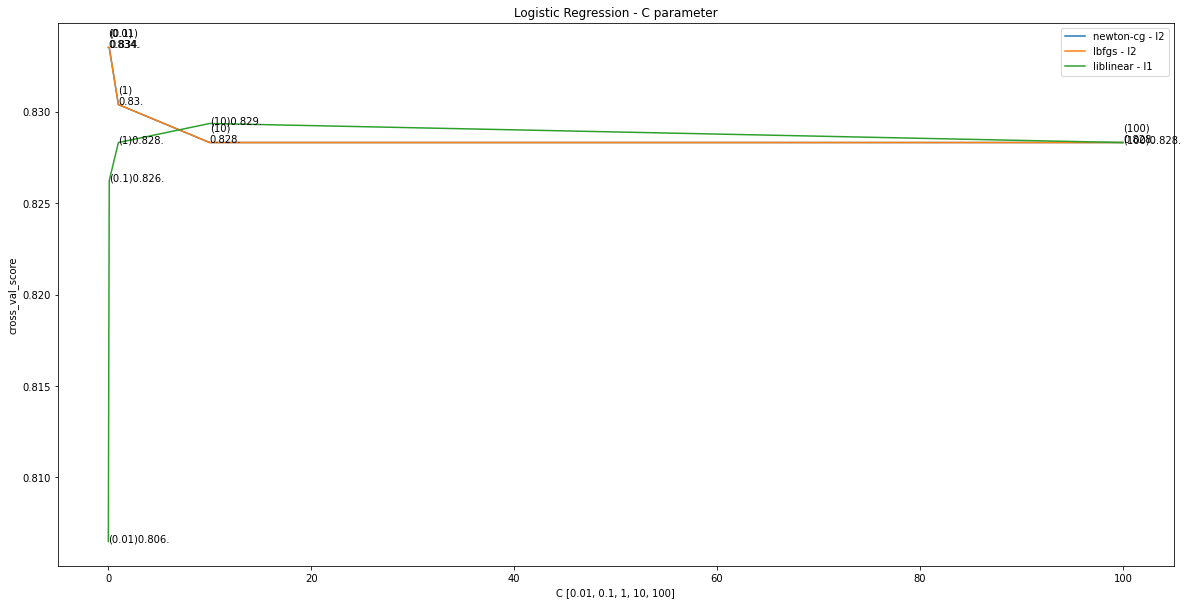

In [31]:
plt.figure(figsize=(20,10))
n = C_param_range
ran = range(0,10, 2)
plt.plot(n, lr_newton_scores, label="newton-cg - l2")
for a,b in zip(n, lr_newton_scores):
    plt.text(a, b, str("\n({})\n{}.".format(a,round(b,3))))

plt.plot(n, lr_lbfgs_scores, label="lbfgs - l2")
#for a,b in zip(n, lr_lbfgs_scores):
#    plt.text(a, b, str("({}){}.".format(a,round(b,3))))

plt.plot(n, lr_liblinear_scores, label="liblinear - l1")
for a,b in zip(n, lr_liblinear_scores):
    plt.text(a, b, str("({}){}.".format(a,round(b,3))))

plt.xlabel('C [0.01, 0.1, 1, 10, 100]\n')
plt.ylabel('cross_val_score')
plt.title('Logistic Regression - C parameter')
plt.legend()
plt.savefig("figures_python/parameters/lr_graph.pdf")

## ROC

In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

In [33]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=N_SPLITS)

tprs_lr = []
aucs_lr = []
mean_fpr_lr = np.linspace(0, 1, 100)


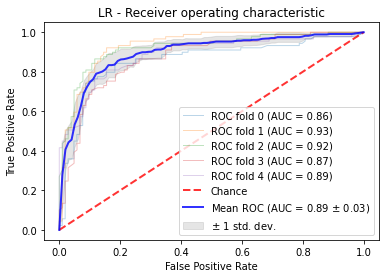

In [34]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    best_lr.fit(X.iloc[train], y.iloc[train])
    viz = plot_roc_curve(best_lr, X.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr_lr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs_lr.append(interp_tpr)
    aucs_lr.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr_lr = np.mean(tprs_lr, axis=0)
mean_tpr_lr[-1] = 1.0
mean_auc_lr = auc(mean_fpr_lr, mean_tpr_lr)
std_auc_lr = np.std(aucs_lr)
ax.plot(mean_fpr_lr, mean_tpr_lr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_lr, std_auc_lr),
        lw=2, alpha=.8)

std_tpr = np.std(tprs_lr, axis=0)
tprs_upper = np.minimum(mean_tpr_lr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_lr - std_tpr, 0)
ax.fill_between(mean_fpr_lr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="LR - Receiver operating characteristic")
ax.legend(loc="lower right")
plt.savefig("figures_python/roc/lr.pdf")
plt.show()

## Tablas de errores y matriz de confusión

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [36]:
y_true, y_pred = y_test, best_lr.predict(X_test)
report = classification_report(y_true, y_pred, output_dict=True)
print("Logistic Regression GridSearch best estimator: ",accuracy_score(y_test, y_pred, normalize = True))

Logistic Regression GridSearch best estimator:  0.8274428274428275


In [37]:
df = pd.DataFrame(report).transpose()
df.head()

,precision,recall,f1-score,support
0,0.833333,0.855513,0.844278,263.000000
1,0.819905,0.793578,0.806527,218.000000
accuracy,0.827443,0.827443,0.827443,0.827443
macro avg,0.826619,0.824546,0.825402,481.000000
weighted avg,0.827247,0.827443,0.827168,481.000000


In [38]:
# export to latex
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &     support \\
\midrule
0            &   0.833333 &  0.855513 &  0.844278 &  263.000000 \\
1            &   0.819905 &  0.793578 &  0.806527 &  218.000000 \\
accuracy     &   0.827443 &  0.827443 &  0.827443 &    0.827443 \\
macro avg    &   0.826619 &  0.824546 &  0.825402 &  481.000000 \\
weighted avg &   0.827247 &  0.827443 &  0.827168 &  481.000000 \\
\bottomrule
\end{tabular}



In [39]:
m = confusion_matrix(y_test, y_pred)
total = m.sum()

In [40]:
print("Verdadero Positivos:", m[0,0]/total)
print("Falsos Positivos:", m[0,1]/total)
print("Verdadero Negativos:", m[1,1]/total)
print("Falsos Negativos:", m[1,0]/total)
ratio = (m[0,0]+m[1,1])/total
print("Acccuracy:", ratio)

Verdadero Positivos: 0.4677754677754678
Falsos Positivos: 0.079002079002079
Verdadero Negativos: 0.3596673596673597
Falsos Negativos: 0.09355509355509356
Acccuracy: 0.8274428274428275


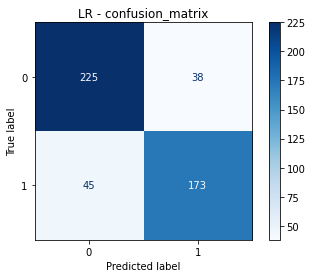

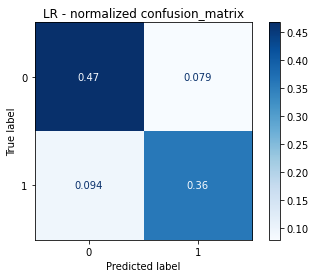

In [41]:
# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(best_lr, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title("LR - confusion_matrix")

plt.savefig("figures_python/confusion_matrix/lr.pdf")
plt.show()

disp = plot_confusion_matrix(best_lr, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='all')
disp.ax_.set_title("LR - normalized confusion_matrix")

plt.savefig("figures_python/confusion_matrix/lr_normalized.pdf")
plt.show()

## Validation curve

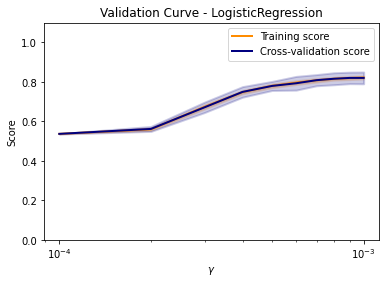

In [42]:
from sklearn.model_selection import validation_curve

param_range = [i / 10000.0 for i in range(1, 11)]

train_scores, test_scores = validation_curve(best_lr, X, y, param_name="clf__C", param_range=param_range, scoring="accuracy", cv=N_SPLITS)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve - LogisticRegression")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.savefig("figures_python/validation_curves/lr.pdf")
plt.show()

## Learning Curve

In [43]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores, fit_times, _ = \
    learning_curve(best_lr, X, y, cv=N_SPLITS, scoring='accuracy', train_sizes=np.linspace(.1, 1.0, 5), return_times=True)

# Create means and standard deviations of training set scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
# Create means and standard deviations of test set scores
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

<function matplotlib.pyplot.show(close=None, block=None)>

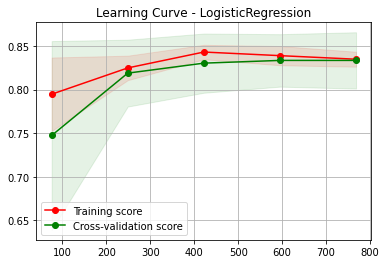

In [44]:
# Learning curve
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1,
                        color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                label="Cross-validation score")
plt.title("Learning Curve - LogisticRegression")
plt.legend(loc="best")
plt.savefig("figures_python/learning_curves/lr.pdf")
plt.show

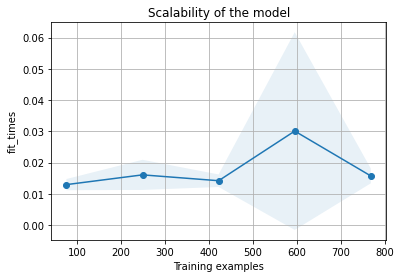

In [45]:
# Plot n_samples vs fit_times
plt.grid()
plt.plot(train_sizes, fit_times_mean, 'o-')
plt.fill_between(train_sizes, fit_times_mean - fit_times_std,
                        fit_times_mean + fit_times_std, alpha=0.1)
plt.xlabel("Training examples")
plt.ylabel("fit_times")
plt.title("Scalability of the model")
plt.savefig("figures_python/learning_curves/lr_scalability.pdf")
plt.show()

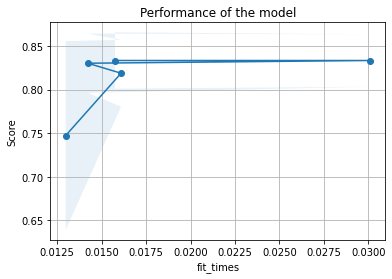

In [46]:
# Plot fit_time vs score
plt.grid()
plt.plot(fit_times_mean, test_scores_mean, 'o-')
plt.fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1)
plt.xlabel("fit_times")
plt.ylabel("Score")
plt.title("Performance of the model")
plt.savefig("figures_python/learning_curves/lr_performance.pdf")
plt.show()

# KNeighborsClassifier

In [47]:
from sklearn.neighbors import KNeighborsClassifier

In [48]:
pipeline = Pipeline(
    [
        ('pre', preprocessor),
        ('clf', KNeighborsClassifier())
    ]
)

In [49]:
get_full_score(pipeline, X, y)

(0.7971124784110535, 0.027536452609151586)

In [50]:
get_full_score_roc_auc(pipeline, X, y)

(0.8691721349992868, 0.023032434282243257)

In [51]:
get_full_score(KNeighborsClassifier(), X_no_nan, y_no_nan)

(0.8004803341454926, 0.0214282105037147)

In [52]:
get_full_score_roc_auc(KNeighborsClassifier(), X_no_nan_scaled, y_no_nan)

(0.8748300392486683, 0.024048660947195412)

In [53]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pre', 'clf', 'pre__n_jobs', 'pre__remainder', 'pre__sparse_threshold', 'pre__transformer_weights', 'pre__transformers', 'pre__verbose', 'pre__cat', 'pre__num', 'pre__cat__memory', 'pre__cat__steps', 'pre__cat__verbose', 'pre__cat__imputer_cat', 'pre__cat__onehot', 'pre__cat__imputer_cat__add_indicator', 'pre__cat__imputer_cat__copy', 'pre__cat__imputer_cat__fill_value', 'pre__cat__imputer_cat__missing_values', 'pre__cat__imputer_cat__strategy', 'pre__cat__imputer_cat__verbose', 'pre__cat__onehot__categories', 'pre__cat__onehot__drop', 'pre__cat__onehot__dtype', 'pre__cat__onehot__handle_unknown', 'pre__cat__onehot__sparse', 'pre__num__memory', 'pre__num__steps', 'pre__num__verbose', 'pre__num__imputer_num', 'pre__num__scaler', 'pre__num__imputer_num__add_indicator', 'pre__num__imputer_num__copy', 'pre__num__imputer_num__fill_value', 'pre__num__imputer_num__missing_values', 'pre__num__imputer_num__strategy', 'pre__num__imputer_num__verbose', 'pr

In [54]:
params_knn = [
    {
        'clf': [KNeighborsClassifier()],   
        'clf__n_neighbors': range(1, 20),
        'clf__metric': ["euclidean", "manhattan", "chebyshev"],
        'pre__num__scaler': [StandardScaler(), MinMaxScaler()],
        'pre__cat__imputer_cat__strategy': ['most_frequent', 'median'],
        'pre__num__imputer_num__strategy': ['mean', 'median']
    }
]

In [55]:
from sklearn.metrics import classification_report


# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=10)

print("# Tuning hyper-parameters for accuracy")
print()

clf = GridSearchCV(pipeline, params_knn, scoring='accuracy', cv=N_SPLITS, refit = True)
clf.fit(X_train, y_train)
print("Best mean cross-validation score: {:.3f}".format(clf.best_score_))
print("Best parameters:", clf.best_params_)
print("test-set score: {:.3f}".format(clf.score(X_test, y_test)))


# Tuning hyper-parameters for accuracy

Best mean cross-validation score: 0.836
Best parameters: {'clf': KNeighborsClassifier(metric='manhattan', n_neighbors=16), 'clf__metric': 'manhattan', 'clf__n_neighbors': 16, 'pre__cat__imputer_cat__strategy': 'most_frequent', 'pre__num__imputer_num__strategy': 'mean', 'pre__num__scaler': StandardScaler()}
test-set score: 0.820


In [56]:
# utilizando el mejor modelo
print("Best estimator:", clf.best_estimator_)
best_knn = clf.best_estimator_
get_full_score(best_knn, X, y)

Best estimator: Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Shape']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['BI-RADS', 'Age', 'Marg

(0.8179134283246977, 0.026233632645637096)

In [57]:
get_full_score_roc_auc(best_knn, X, y)

(0.8968349053041429, 0.02186760146965614)

## Tabla

In [58]:
df_report = pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
df_report = df_report.sort_values(by=['Accuracy'], ascending=False)
df_report = df_report.dropna()
df_report =df_report.drop(['clf'], axis=1)
df_report.head()

,clf__metric,clf__n_neighbors,pre__cat__imputer_cat__strategy,pre__num__imputer_num__strategy,pre__num__scaler,Accuracy
278,manhattan,16,median,median,StandardScaler(),0.836022
272,manhattan,16,most_frequent,mean,StandardScaler(),0.836022
276,manhattan,16,median,mean,StandardScaler(),0.836022
274,manhattan,16,most_frequent,median,StandardScaler(),0.836022
280,manhattan,17,most_frequent,mean,StandardScaler(),0.833424


In [59]:
# export to latex
print(df_report.to_latex(index=False))

\begin{tabular}{lrlllr}
\toprule
clf\_\_metric &  clf\_\_n\_neighbors & pre\_\_cat\_\_imputer\_cat\_\_strategy & pre\_\_num\_\_imputer\_num\_\_strategy &  pre\_\_num\_\_scaler &  Accuracy \\
\midrule
  manhattan &                16 &                          median &                          median &  StandardScaler() &  0.836022 \\
  manhattan &                16 &                   most\_frequent &                            mean &  StandardScaler() &  0.836022 \\
  manhattan &                16 &                          median &                            mean &  StandardScaler() &  0.836022 \\
  manhattan &                16 &                   most\_frequent &                          median &  StandardScaler() &  0.836022 \\
  manhattan &                17 &                   most\_frequent &                            mean &  StandardScaler() &  0.833424 \\
  manhattan &                17 &                          median &                            mean &  StandardScaler() & 

## Gráfica

In [60]:
categorical_features = ['Shape']
categorical_transformer_knn = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy='median')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

numeric_features = ['BI-RADS','Age', 'Margin', 'Density']
numeric_transformer_knn = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

preprocessor_knn = ColumnTransformer(
    [
        ('cat', categorical_transformer_knn, categorical_features),
        ('num', numeric_transformer_knn, numeric_features)
    ]
)

In [61]:
knn, knn_euc, knn_man, knn_cheb = [], [], [], [] 
distances = ["euclidean", "manhattan", "chebyshev", "minkowski"]
n = range(1, 20)
for i in n:
    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    knc_euc = Pipeline(steps=[('preprocessor', preprocessor_knn), ('classifier', KNeighborsClassifier(n_neighbors = i, metric = 'euclidean'))])
    knc_man = Pipeline(steps=[('preprocessor', preprocessor_knn), ('classifier', KNeighborsClassifier(n_neighbors = i, metric = 'manhattan'))])
    knc_cheb = Pipeline(steps=[('preprocessor', preprocessor_knn), ('classifier', KNeighborsClassifier(n_neighbors = i, metric = 'chebyshev'))])
    knn_euc.append(get_full_score(knc_euc, X_no_nan, y_no_nan)[0])
    knn_man.append(get_full_score(knc_man, X_no_nan, y_no_nan)[0])
    knn_cheb.append(get_full_score(knc_cheb, X_no_nan, y_no_nan)[0])

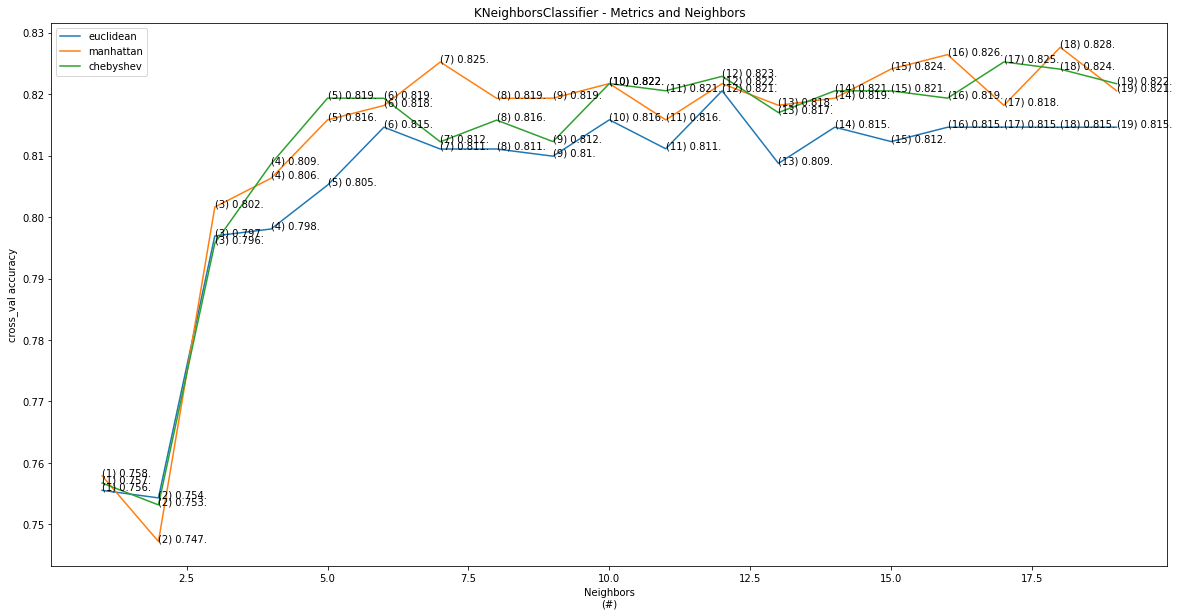

In [62]:
plt.figure(figsize=(20,10))

plt.plot(n, knn_euc, label = "euclidean")
for a,b in zip(n, knn_euc):
    plt.text(a, b, str("({}) {}.".format(a,round(b,3))))
plt.xlabel('Neighbors\n(#)')
plt.ylabel('cross_val accuracy')

plt.plot(n, knn_man, label = "manhattan")
for a,b in zip(n, knn_man):
    plt.text(a, b, str("({}) {}.".format(a,round(b,3))))
plt.xlabel('Neighbors\n(#)')
plt.ylabel('cross_val accuracy')

plt.plot(n, knn_cheb, label = "chebyshev")
for a,b in zip(n, knn_cheb):
    plt.text(a, b, str("({}) {}.".format(a,round(b,3))))
plt.xlabel('Neighbors\n(#)')
plt.ylabel('cross_val accuracy')
plt.title('KNeighborsClassifier - Metrics and Neighbors')
plt.legend()
plt.savefig("figures_python/parameters/knn_graph.pdf")
plt.show()

## Tabla de error y matriz de confusión

In [63]:
y_true, y_pred = y_test, best_knn.predict(X_test)
report = classification_report(y_true, y_pred, output_dict=True)
print("KNeighborsClassifier GridSearch best estimator: ",accuracy_score(y_test, y_pred, normalize = True))

KNeighborsClassifier GridSearch best estimator:  0.8197573656845754


In [64]:
df = pd.DataFrame(report).transpose()
df.head()
# Export to latex
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &     support \\
\midrule
0            &   0.807580 &  0.879365 &  0.841945 &  315.000000 \\
1            &   0.837607 &  0.748092 &  0.790323 &  262.000000 \\
accuracy     &   0.819757 &  0.819757 &  0.819757 &    0.819757 \\
macro avg    &   0.822594 &  0.813728 &  0.816134 &  577.000000 \\
weighted avg &   0.821214 &  0.819757 &  0.818505 &  577.000000 \\
\bottomrule
\end{tabular}



In [65]:
m = confusion_matrix(y_test, y_pred)
print(m)
total = m.sum()
print("Verdadero Positivos:", m[0,0]/total)
print("Falsos Positivos:", m[0,1]/total)
print("Verdadero Negativos:", m[1,1]/total)
print("Falsos Negativos:", m[1,0]/total)
ratio = (m[0,0]+m[1,1])/total
print("Acccuracy:", ratio)

[[277  38]
 [ 66 196]]
Verdadero Positivos: 0.4800693240901213
Falsos Positivos: 0.0658578856152513
Verdadero Negativos: 0.3396880415944541
Falsos Negativos: 0.11438474870017332
Acccuracy: 0.8197573656845754


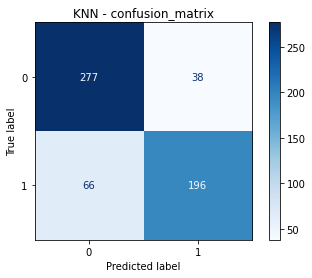

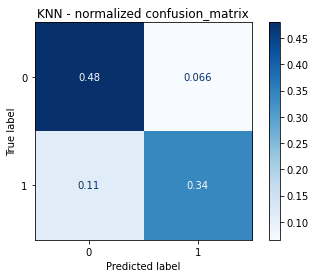

In [66]:
# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(best_knn, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title("KNN - confusion_matrix")

plt.savefig("figures_python/confusion_matrix/knn.pdf")
plt.show()

disp = plot_confusion_matrix(best_knn, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='all')
disp.ax_.set_title("KNN - normalized confusion_matrix")

plt.savefig("figures_python/confusion_matrix/knn_normalized.pdf")
plt.show()

## ROC

In [67]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=N_SPLITS)

tprs_knn = []
aucs_knn = []
mean_fpr_knn = np.linspace(0, 1, 100)

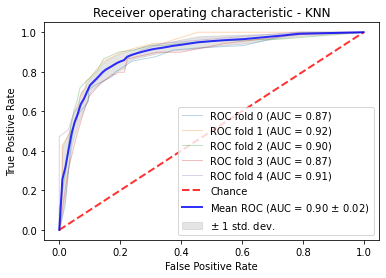

In [68]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    best_knn.fit(X.iloc[train], y.iloc[train])
    viz = plot_roc_curve(best_knn, X.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr_knn, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs_knn.append(interp_tpr)
    aucs_knn.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr_knn = np.mean(tprs_knn, axis=0)
mean_tpr_knn[-1] = 1.0
mean_auc_knn = auc(mean_fpr_knn, mean_tpr_knn)
std_auc_knn = np.std(aucs_knn)
ax.plot(mean_fpr_knn, mean_tpr_knn, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_knn, std_auc_knn),
        lw=2, alpha=.8)

std_tpr = np.std(tprs_knn, axis=0)
tprs_upper = np.minimum(mean_tpr_knn + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_knn - std_tpr, 0)
ax.fill_between(mean_fpr_knn, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic - KNN")
ax.legend(loc="lower right")
plt.savefig("figures_python/roc/knn.pdf")
plt.show()

## Validation curve

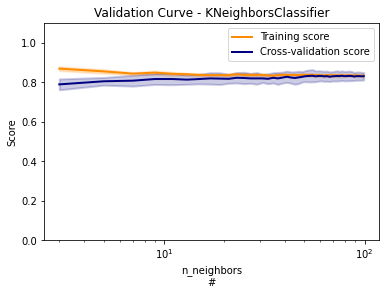

In [69]:
from sklearn.model_selection import validation_curve

param_range = np.arange(3, 100, 2)

train_scores, test_scores = validation_curve(best_knn, X, y, param_name="clf__n_neighbors", param_range=param_range, scoring="accuracy", cv=N_SPLITS)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve - KNeighborsClassifier")
plt.xlabel("n_neighbors\n#")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.savefig("figures_python/validation_curves/knn.pdf")
plt.show()

## Learning Curve

In [70]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores, fit_times, _ = \
    learning_curve(best_knn, X, y, cv=N_SPLITS, scoring='accuracy', train_sizes=np.linspace(.1, 1.0, 5), return_times=True)

# Create means and standard deviations of training set scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
# Create means and standard deviations of test set scores
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

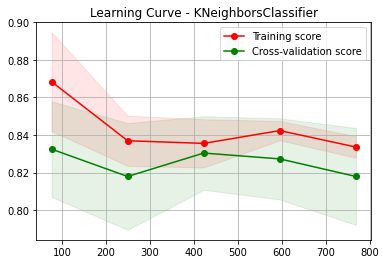

In [71]:
# Learning curve
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1,
                        color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                label="Cross-validation score")
plt.title("Learning Curve - KNeighborsClassifier")
plt.legend(loc="best")
plt.savefig("figures_python/learning_curves/knn.pdf")
plt.show()

## Scalability

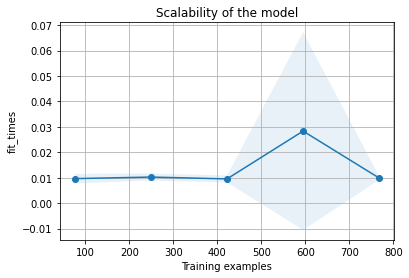

In [72]:
# Plot n_samples vs fit_times
plt.grid()
plt.plot(train_sizes, fit_times_mean, 'o-')
plt.fill_between(train_sizes, fit_times_mean - fit_times_std,
                        fit_times_mean + fit_times_std, alpha=0.1)
plt.xlabel("Training examples")
plt.ylabel("fit_times")
plt.title("Scalability of the model")
plt.savefig("figures_python/learning_curves/knn_scalability.pdf")
plt.show()

## Performace

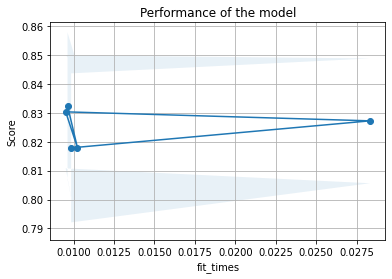

In [73]:
# Plot fit_time vs score
plt.grid()
plt.plot(fit_times_mean, test_scores_mean, 'o-')
plt.fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1)
plt.xlabel("fit_times")
plt.ylabel("Score")
plt.title("Performance of the model")
plt.savefig("figures_python/learning_curves/knn_performance.pdf")
plt.show()

# SVC

In [74]:
from sklearn.svm import SVC

In [75]:
pipeline = Pipeline(
    [
        ('pre', preprocessor),
        ('clf', SVC())
    ]
)

In [76]:
get_full_score(pipeline, X, y)

(0.8272776338514681, 0.04086356732521057)

In [77]:
get_full_score_roc_auc(pipeline, X, y)

(0.8877485923588793, 0.03530546059034995)

In [78]:
get_full_score(SVC(), X_no_nan, y_no_nan)

(0.781594152453881, 0.02281312941452145)

In [79]:
get_full_score_roc_auc(SVC(), X_no_nan, y_no_nan)

(0.8737170910110356, 0.020431972174570823)

In [80]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pre', 'clf', 'pre__n_jobs', 'pre__remainder', 'pre__sparse_threshold', 'pre__transformer_weights', 'pre__transformers', 'pre__verbose', 'pre__cat', 'pre__num', 'pre__cat__memory', 'pre__cat__steps', 'pre__cat__verbose', 'pre__cat__imputer_cat', 'pre__cat__onehot', 'pre__cat__imputer_cat__add_indicator', 'pre__cat__imputer_cat__copy', 'pre__cat__imputer_cat__fill_value', 'pre__cat__imputer_cat__missing_values', 'pre__cat__imputer_cat__strategy', 'pre__cat__imputer_cat__verbose', 'pre__cat__onehot__categories', 'pre__cat__onehot__drop', 'pre__cat__onehot__dtype', 'pre__cat__onehot__handle_unknown', 'pre__cat__onehot__sparse', 'pre__num__memory', 'pre__num__steps', 'pre__num__verbose', 'pre__num__imputer_num', 'pre__num__scaler', 'pre__num__imputer_num__add_indicator', 'pre__num__imputer_num__copy', 'pre__num__imputer_num__fill_value', 'pre__num__imputer_num__missing_values', 'pre__num__imputer_num__strategy', 'pre__num__imputer_num__verbose', 'pr

In [81]:
params_svc = [
    {
        'clf': [SVC(random_state=10)],  
        'clf__kernel': ["linear", "poly", "rbf", "sigmoid"],
        'clf__C': [0.01, 0.1, 1, 10, 100],
        'clf__gamma': ['auto', 'scale'],
        'pre__num__scaler': [StandardScaler(), MinMaxScaler()],
        'pre__cat__imputer_cat__strategy': ['most_frequent', 'median'],
        'pre__num__imputer_num__strategy': ['mean', 'median']
    }
]

In [82]:
from sklearn.metrics import classification_report


# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=10)

print("# Tuning hyper-parameters for accuracy")
print()

clf = GridSearchCV(pipeline, params_svc, scoring='accuracy', cv=N_SPLITS, refit = True)
clf.fit(X_train, y_train)
print("Best mean cross-validation score: {:.3f}".format(clf.best_score_))
print("Best parameters:", clf.best_params_)
print("test-set score: {:.3f}".format(clf.score(X_test, y_test)))


# Tuning hyper-parameters for accuracy

Best mean cross-validation score: 0.833
Best parameters: {'clf': SVC(C=1, gamma='auto', random_state=10), 'clf__C': 1, 'clf__gamma': 'auto', 'clf__kernel': 'rbf', 'pre__cat__imputer_cat__strategy': 'most_frequent', 'pre__num__imputer_num__strategy': 'mean', 'pre__num__scaler': StandardScaler()}
test-set score: 0.820


In [83]:
# utilizando el mejor modelo
best_svc = clf.best_estimator_
print("Best estimator SVC:", best_svc)
get_full_score(best_svc, X, y)

Best estimator SVC: Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Shape']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['BI-RADS', 'Age', '

(0.8283246977547496, 0.03887076020885105)

## Tabla de combinaciones SVC

In [84]:
df_report = pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
df_report = df_report.sort_values(by=['Accuracy'], ascending=False)
df_report = df_report.dropna()
df_report =df_report.drop(['clf'], axis=1)
df_report.head()

,clf__C,clf__gamma,clf__kernel,pre__cat__imputer_cat__strategy,pre__num__imputer_num__strategy,pre__num__scaler,Accuracy
144,1.0,auto,rbf,most_frequent,mean,StandardScaler(),0.833356
148,1.0,auto,rbf,median,mean,StandardScaler(),0.833356
150,1.0,auto,rbf,median,median,StandardScaler(),0.830725
146,1.0,auto,rbf,most_frequent,median,StandardScaler(),0.830725
176,1.0,scale,rbf,most_frequent,mean,StandardScaler(),0.820335


In [85]:
# export to latex
print(df_report.to_latex(index=False))

\begin{tabular}{rlllllr}
\toprule
 clf\_\_C & clf\_\_gamma & clf\_\_kernel & pre\_\_cat\_\_imputer\_cat\_\_strategy & pre\_\_num\_\_imputer\_num\_\_strategy &  pre\_\_num\_\_scaler &  Accuracy \\
\midrule
   1.00 &       auto &         rbf &                   most\_frequent &                            mean &  StandardScaler() &  0.833356 \\
   1.00 &       auto &         rbf &                          median &                            mean &  StandardScaler() &  0.833356 \\
   1.00 &       auto &         rbf &                          median &                          median &  StandardScaler() &  0.830725 \\
   1.00 &       auto &         rbf &                   most\_frequent &                          median &  StandardScaler() &  0.830725 \\
   1.00 &      scale &         rbf &                   most\_frequent &                            mean &  StandardScaler() &  0.820335 \\
   1.00 &      scale &         rbf &                   most\_frequent &                          media

## Gráfica

In [86]:
categorical_features = ['Shape']
categorical_transformer_svc = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

numeric_features = ['BI-RADS','Age', 'Margin', 'Density']
numeric_transformer_svc = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

preprocessor_svc = ColumnTransformer(
    [
        ('cat', categorical_transformer_knn, categorical_features),
        ('num', numeric_transformer_knn, numeric_features)
    ]
)

In [87]:
C_param_range = [0.01, 0.1, 1, 10, 100]
svc_linear, svc_poly, svc_rbf, svc_sigmoid = [], [], [], []
for i in C_param_range:
    linear = Pipeline(steps=[('preprocessor', preprocessor_svc), ('classifier', SVC(C = i, gamma ='auto',kernel='linear', random_state=10))])
    poly = Pipeline(steps=[('preprocessor', preprocessor_svc), ('classifier', SVC(C = i, gamma ='auto', kernel='poly', random_state=10))])
    rbf = Pipeline(steps=[('preprocessor', preprocessor_svc), ('classifier', SVC(C = i, gamma ='auto', kernel='rbf', random_state=10))])
    sigmoid = Pipeline(steps=[('preprocessor', preprocessor_svc), ('classifier', SVC(C = i, gamma ='auto', kernel='sigmoid', random_state=10))])
    svc_linear.append(get_full_score(linear, X, y)[0])
    svc_poly.append(get_full_score(poly, X, y)[0])
    svc_rbf.append(get_full_score(rbf, X, y)[0])
    svc_sigmoid.append(get_full_score(sigmoid, X, y)[0])

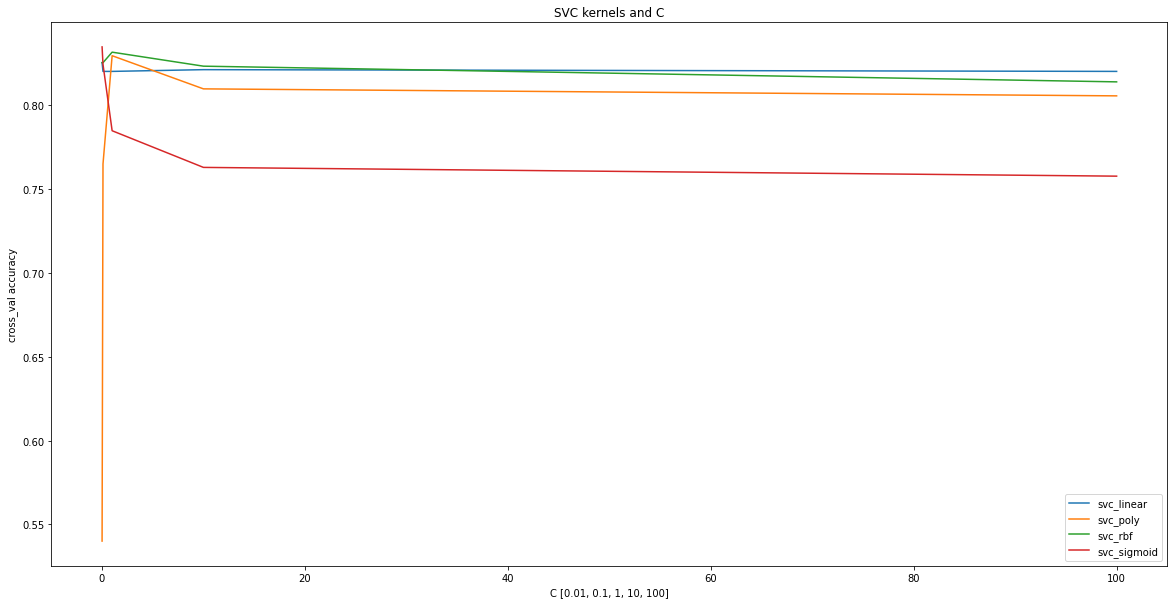

In [88]:
plt.figure(figsize=(20,10))
n = C_param_range
ran = range(0,10, 2)
plt.plot(n, svc_linear, label="svc_linear")
plt.plot(n, svc_poly, label="svc_poly")
plt.plot(n, svc_rbf, label="svc_rbf")
plt.plot(n, svc_sigmoid, label="svc_sigmoid")

plt.xlabel('C [0.01, 0.1, 1, 10, 100]')
plt.ylabel('cross_val accuracy')
plt.title('SVC kernels and C')
plt.legend()
plt.savefig("figures_python/parameters/svc_graph.pdf")
plt.show()

## Tabla de error y matriz de confusión

In [89]:
y_true, y_pred = y_test, best_svc.predict(X_test)
report = classification_report(y_true, y_pred, output_dict=True)
print("SVC GridSearch best estimator: ",accuracy_score(y_test, y_pred, normalize = True))

SVC GridSearch best estimator:  0.8197573656845754


In [90]:
df = pd.DataFrame(report).transpose()
# Export to latex
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &     support \\
\midrule
0            &   0.813056 &  0.869841 &  0.840491 &  315.000000 \\
1            &   0.829167 &  0.759542 &  0.792829 &  262.000000 \\
accuracy     &   0.819757 &  0.819757 &  0.819757 &    0.819757 \\
macro avg    &   0.821112 &  0.814692 &  0.816660 &  577.000000 \\
weighted avg &   0.820372 &  0.819757 &  0.818849 &  577.000000 \\
\bottomrule
\end{tabular}



In [91]:
m = confusion_matrix(y_test, y_pred)
print(m)
total = m.sum()
print("Verdadero Positivos:", m[0,0]/total)
print("Falsos Positivos:", m[0,1]/total)
print("Verdadero Negativos:", m[1,1]/total)
print("Falsos Negativos:", m[1,0]/total)
ratio = (m[0,0]+m[1,1])/total
print("Acccuracy:", ratio)

[[274  41]
 [ 63 199]]
Verdadero Positivos: 0.4748700173310225
Falsos Positivos: 0.07105719237435008
Verdadero Negativos: 0.34488734835355284
Falsos Negativos: 0.10918544194107452
Acccuracy: 0.8197573656845754


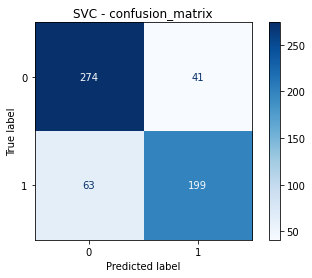

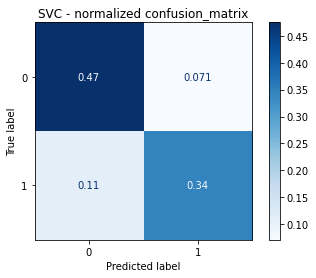

In [92]:
# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(best_svc, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title("SVC - confusion_matrix")

plt.savefig("figures_python/confusion_matrix/svc.pdf")
plt.show()

disp = plot_confusion_matrix(best_svc, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='all')
disp.ax_.set_title("SVC - normalized confusion_matrix")

plt.savefig("figures_python/confusion_matrix/svc_normalized.pdf")
plt.show()

## ROC

In [93]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=N_SPLITS)

tprs_svc = []
aucs_svc = []
mean_fpr_svc = np.linspace(0, 1, 100)

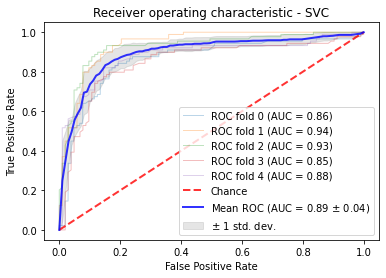

In [94]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    best_svc.fit(X.iloc[train], y.iloc[train])
    viz = plot_roc_curve(best_svc, X.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr_svc, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs_svc.append(interp_tpr)
    aucs_svc.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr_svc = np.mean(tprs_svc, axis=0)
mean_tpr_svc[-1] = 1.0
mean_auc_svc = auc(mean_fpr_svc, mean_tpr_svc)
std_auc_svc = np.std(aucs_svc)
ax.plot(mean_fpr_svc, mean_tpr_svc, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_svc, std_auc_svc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs_svc, axis=0)
tprs_upper = np.minimum(mean_tpr_svc + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_svc - std_tpr, 0)
ax.fill_between(mean_fpr_svc, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic - SVC")
ax.legend(loc="lower right")
plt.savefig("figures_python/roc/svc.pdf")
plt.show()

## Validation Curve

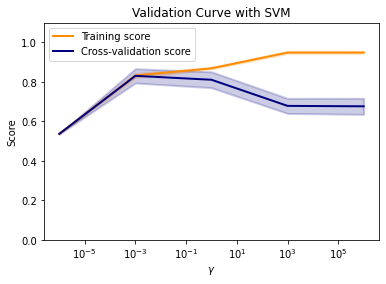

In [95]:
from sklearn.model_selection import validation_curve

param_range = np.logspace(-6, 6, 5)
train_scores, test_scores = validation_curve(best_svc, X, y, param_name="clf__gamma", param_range=param_range, scoring="accuracy", cv=N_SPLITS)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.savefig("figures_python/validation_curves/svc.pdf")
plt.show()

## Learning Curve

In [96]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores, fit_times, _ = \
    learning_curve(best_svc, X, y, cv=N_SPLITS, scoring='accuracy', train_sizes=np.linspace(.1, 1.0, 5), return_times=True)

# Create means and standard deviations of training set scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
# Create means and standard deviations of test set scores
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

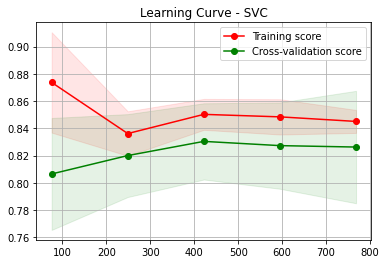

In [97]:
# Learning curve
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1,
                        color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                label="Cross-validation score")
plt.title("Learning Curve - SVC")
plt.legend(loc="best")
plt.savefig("figures_python/learning_curves/svc.pdf")
plt.show()

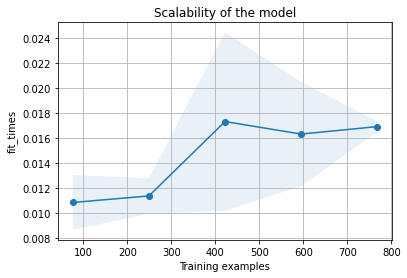

In [98]:
# Plot n_samples vs fit_times
plt.grid()
plt.plot(train_sizes, fit_times_mean, 'o-')
plt.fill_between(train_sizes, fit_times_mean - fit_times_std,
                        fit_times_mean + fit_times_std, alpha=0.1)
plt.xlabel("Training examples")
plt.ylabel("fit_times")
plt.title("Scalability of the model")
plt.savefig("figures_python/learning_curves/svc_scalability.pdf")
plt.show()

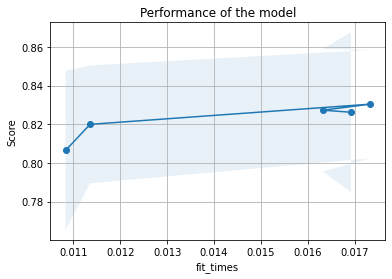

In [99]:
# Plot fit_time vs score
plt.grid()
plt.plot(fit_times_mean, test_scores_mean, 'o-')
plt.fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1)
plt.xlabel("fit_times")
plt.ylabel("Score")
plt.title("Performance of the model")
plt.savefig("figures_python/learning_curves/svc_performance.pdf")
plt.show()

# GradientBoostingClassifier 

In [100]:
from sklearn.ensemble import GradientBoostingClassifier

In [101]:
pipeline = Pipeline(
    [
        ('pre', preprocessor),
        ('clf', GradientBoostingClassifier())
    ]
)

In [102]:
get_full_score(pipeline, X, y)

(0.8189496977547496, 0.02982750965326393)

In [103]:
get_full_score_roc_auc(pipeline, X, y)

(0.8870838962499266, 0.023454454924503387)

In [104]:
get_full_score(GradientBoostingClassifier(), X_no_nan, y_no_nan)

(0.8252210233205709, 0.030503485185654936)

In [105]:
get_full_score_roc_auc(GradientBoostingClassifier(), X_no_nan, y_no_nan)

(0.892535425746107, 0.022627818282828616)

In [106]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pre', 'clf', 'pre__n_jobs', 'pre__remainder', 'pre__sparse_threshold', 'pre__transformer_weights', 'pre__transformers', 'pre__verbose', 'pre__cat', 'pre__num', 'pre__cat__memory', 'pre__cat__steps', 'pre__cat__verbose', 'pre__cat__imputer_cat', 'pre__cat__onehot', 'pre__cat__imputer_cat__add_indicator', 'pre__cat__imputer_cat__copy', 'pre__cat__imputer_cat__fill_value', 'pre__cat__imputer_cat__missing_values', 'pre__cat__imputer_cat__strategy', 'pre__cat__imputer_cat__verbose', 'pre__cat__onehot__categories', 'pre__cat__onehot__drop', 'pre__cat__onehot__dtype', 'pre__cat__onehot__handle_unknown', 'pre__cat__onehot__sparse', 'pre__num__memory', 'pre__num__steps', 'pre__num__verbose', 'pre__num__imputer_num', 'pre__num__scaler', 'pre__num__imputer_num__add_indicator', 'pre__num__imputer_num__copy', 'pre__num__imputer_num__fill_value', 'pre__num__imputer_num__missing_values', 'pre__num__imputer_num__strategy', 'pre__num__imputer_num__verbose', 'pr

In [107]:
params_gbc = [
    {
        'clf': [GradientBoostingClassifier(random_state=10)],  
        "clf__max_depth":[1,3,5,8],
        "clf__n_estimators":[1,10,50,100,200],
        'pre__cat__imputer_cat__strategy': ['most_frequent', 'median'],
        'pre__num__imputer_num__strategy': ['mean', 'median']
    }
]


In [108]:
from sklearn.metrics import classification_report


# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=10)

print("# Tuning hyper-parameters for accuracy")
print()

clf = GridSearchCV(pipeline, params_gbc, scoring='accuracy', cv=N_SPLITS, refit = True)
clf.fit(X_train, y_train)
print("Best mean cross-validation score: {:.3f}".format(clf.best_score_))
print("Best parameters:", clf.best_params_)
print("test-set score: {:.3f}".format(clf.score(X_test, y_test)))

# Tuning hyper-parameters for accuracy

Best mean cross-validation score: 0.835
Best parameters: {'clf': GradientBoostingClassifier(n_estimators=1, random_state=10), 'clf__max_depth': 3, 'clf__n_estimators': 1, 'pre__cat__imputer_cat__strategy': 'most_frequent', 'pre__num__imputer_num__strategy': 'median'}
test-set score: 0.813


In [109]:
# utilizando el mejor modelo
best_gbc = clf.best_estimator_
print("Best estimator:", best_gbc)
get_full_score(best_gbc, X, y)

Best estimator: Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Shape']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['BI-RA

(0.785627158894646, 0.03710160085379686)

## Tabla

In [110]:
df_report = pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
df_report = df_report.sort_values(by=['Accuracy'], ascending=False)
df_report = df_report.dropna()
df_report =df_report.drop(['clf'], axis=1)
df_report.head()

,clf__max_depth,clf__n_estimators,pre__cat__imputer_cat__strategy,pre__num__imputer_num__strategy,Accuracy
23,3,1,median,median,0.835417
21,3,1,most_frequent,median,0.835417
22,3,1,median,mean,0.833333
20,3,1,most_frequent,mean,0.833333
9,1,50,most_frequent,median,0.833333


In [111]:
# export to latex
print(df_report.to_latex(index=False))

\begin{tabular}{rrllr}
\toprule
 clf\_\_max\_depth &  clf\_\_n\_estimators & pre\_\_cat\_\_imputer\_cat\_\_strategy & pre\_\_num\_\_imputer\_num\_\_strategy &  Accuracy \\
\midrule
              3 &                  1 &                          median &                          median &  0.835417 \\
              3 &                  1 &                   most\_frequent &                          median &  0.835417 \\
              3 &                  1 &                          median &                            mean &  0.833333 \\
              3 &                  1 &                   most\_frequent &                            mean &  0.833333 \\
              1 &                 50 &                   most\_frequent &                          median &  0.833333 \\
              1 &                 50 &                          median &                          median &  0.833333 \\
              1 &                200 &                          median &                        

## Gráfica

In [112]:
categorical_features = ['Shape']
categorical_transformer_bc = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

numeric_features = ['BI-RADS','Age', 'Margin', 'Density']
numeric_transformer_bc = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())
    ]
)

preprocessor_bc = ColumnTransformer(
    [
        ('cat', categorical_transformer_bc, categorical_features),
        ('num', numeric_transformer_bc, numeric_features)
    ]
)

## Tabla de error y matriz de confusión

In [113]:
y_true, y_pred = y_test, best_gbc.predict(X_test)
report = classification_report(y_true, y_pred, output_dict=True)
print("GradientBoostingClassifier GridSearch best estimator: ",accuracy_score(y_test, y_pred, normalize = True))

GradientBoostingClassifier GridSearch best estimator:  0.8128898128898129


In [114]:
df = pd.DataFrame(report).transpose()
# Export to latex
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &    support \\
\midrule
0            &   0.807829 &  0.863118 &  0.834559 &  263.00000 \\
1            &   0.820000 &  0.752294 &  0.784689 &  218.00000 \\
accuracy     &   0.812890 &  0.812890 &  0.812890 &    0.81289 \\
macro avg    &   0.813915 &  0.807706 &  0.809624 &  481.00000 \\
weighted avg &   0.813345 &  0.812890 &  0.811957 &  481.00000 \\
\bottomrule
\end{tabular}



In [115]:
m = confusion_matrix(y_test, y_pred)
print(m)
total = m.sum()
print("Verdadero Positivos:", m[0,0]/total)
print("Falsos Positivos:", m[0,1]/total)
print("Verdadero Negativos:", m[1,1]/total)
print("Falsos Negativos:", m[1,0]/total)
ratio = (m[0,0]+m[1,1])/total
print("Acccuracy:", ratio)

[[227  36]
 [ 54 164]]
Verdadero Positivos: 0.47193347193347196
Falsos Positivos: 0.07484407484407485
Verdadero Negativos: 0.340956340956341
Falsos Negativos: 0.11226611226611227
Acccuracy: 0.8128898128898129


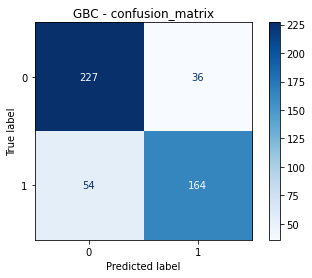

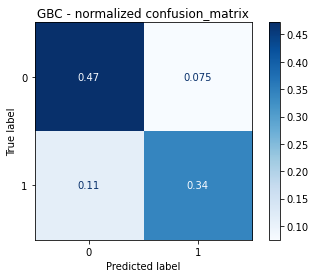

In [116]:
# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(best_gbc, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title("GBC - confusion_matrix")

plt.savefig("figures_python/confusion_matrix/gbc.pdf")
plt.show()

disp = plot_confusion_matrix(best_gbc, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='all')
disp.ax_.set_title("GBC - normalized confusion_matrix")

plt.savefig("figures_python/confusion_matrix/gbc_normalized.pdf")
plt.show()

## ROC

In [117]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=N_SPLITS)

tprs_gbc = []
aucs_gbc = []
mean_fpr_gbc = np.linspace(0, 1, 100)

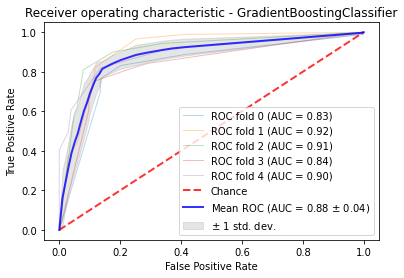

In [118]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    best_gbc.fit(X.iloc[train], y.iloc[train])
    viz = plot_roc_curve(best_gbc, X.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr_gbc, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs_gbc.append(interp_tpr)
    aucs_gbc.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr_gbc= np.mean(tprs_gbc, axis=0)
mean_tpr_gbc[-1] = 1.0
mean_auc_gbc = auc(mean_fpr_gbc, mean_tpr_gbc)
std_auc_gbc = np.std(aucs_gbc)
ax.plot(mean_fpr_gbc, mean_tpr_gbc, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_gbc, std_auc_gbc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs_gbc, axis=0)
tprs_upper = np.minimum(mean_tpr_gbc + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_gbc - std_tpr, 0)
ax.fill_between(mean_fpr_gbc, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic - GradientBoostingClassifier")
ax.legend(loc="lower right")
plt.savefig("figures_python/roc/gbc.pdf")
plt.show()

## Validation curve

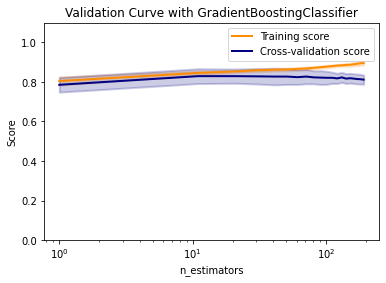

In [119]:
n = range(1,200,10)
#learning_rate
train_scores, test_scores = validation_curve(best_gbc, X, y, param_name="clf__n_estimators", param_range=n, scoring="accuracy", cv=N_SPLITS)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with GradientBoostingClassifier")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(n, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(n, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(n, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(n, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.savefig("figures_python/validation_curves/gbc.pdf")
plt.show()

## Learning Curve

In [120]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores, fit_times, _ = \
    learning_curve(best_gbc, X, y, cv=N_SPLITS, scoring='accuracy', train_sizes=np.linspace(.1, 1.0, 5), return_times=True)

# Create means and standard deviations of training set scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
# Create means and standard deviations of test set scores
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

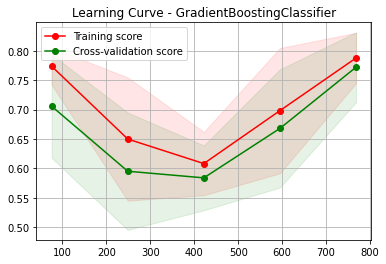

In [121]:
# Learning curve
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1,
                        color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                label="Cross-validation score")
plt.title("Learning Curve - GradientBoostingClassifier")
plt.legend(loc="best")
plt.savefig("figures_python/learning_curves/gbc.pdf")
plt.show()

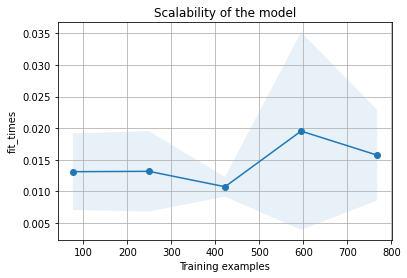

In [122]:
# Plot n_samples vs fit_times
plt.grid()
plt.plot(train_sizes, fit_times_mean, 'o-')
plt.fill_between(train_sizes, fit_times_mean - fit_times_std,
                        fit_times_mean + fit_times_std, alpha=0.1)
plt.xlabel("Training examples")
plt.ylabel("fit_times")
plt.title("Scalability of the model")
plt.savefig("figures_python/learning_curves/gbc_scalability.pdf")
plt.show()

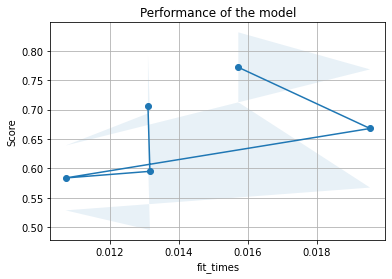

In [123]:
# Plot fit_time vs score
plt.grid()
plt.plot(fit_times_mean, test_scores_mean, 'o-')
plt.fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1)
plt.xlabel("fit_times")
plt.ylabel("Score")
plt.title("Performance of the model")
plt.savefig("figures_python/learning_curves/gbc_performance.pdf")
plt.show()

# Random Forest


In [124]:
from sklearn.ensemble import RandomForestClassifier

In [125]:
pipeline = Pipeline(
    [
        ('pre', preprocessor),
        ('clf', RandomForestClassifier())
    ]
)

In [126]:
get_full_score(pipeline, X, y)

(0.7981325561312608, 0.03039962368668105)

In [127]:
get_full_score_roc_auc(pipeline, X, y)

(0.8647856861149105, 0.02058659274028284)

In [128]:
get_full_score(RandomForestClassifier(), X_no_nan, y_no_nan)

(0.7791924817264183, 0.03110082095587249)

In [129]:
get_full_score_roc_auc(RandomForestClassifier(), X_no_nan, y_no_nan)

(0.8696968104085429, 0.02214293072155099)

In [130]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pre', 'clf', 'pre__n_jobs', 'pre__remainder', 'pre__sparse_threshold', 'pre__transformer_weights', 'pre__transformers', 'pre__verbose', 'pre__cat', 'pre__num', 'pre__cat__memory', 'pre__cat__steps', 'pre__cat__verbose', 'pre__cat__imputer_cat', 'pre__cat__onehot', 'pre__cat__imputer_cat__add_indicator', 'pre__cat__imputer_cat__copy', 'pre__cat__imputer_cat__fill_value', 'pre__cat__imputer_cat__missing_values', 'pre__cat__imputer_cat__strategy', 'pre__cat__imputer_cat__verbose', 'pre__cat__onehot__categories', 'pre__cat__onehot__drop', 'pre__cat__onehot__dtype', 'pre__cat__onehot__handle_unknown', 'pre__cat__onehot__sparse', 'pre__num__memory', 'pre__num__steps', 'pre__num__verbose', 'pre__num__imputer_num', 'pre__num__scaler', 'pre__num__imputer_num__add_indicator', 'pre__num__imputer_num__copy', 'pre__num__imputer_num__fill_value', 'pre__num__imputer_num__missing_values', 'pre__num__imputer_num__strategy', 'pre__num__imputer_num__verbose', 'pr

In [131]:
params_rf = [
    {
        'clf': [RandomForestClassifier(random_state=10)],  
        'clf__n_estimators': [10, 100, 500],
        'clf__max_depth': range(0,4),
        'pre__cat__imputer_cat__strategy': ['most_frequent', 'median'],
        'pre__num__imputer_num__strategy': ['mean', 'median']
    }
]

In [132]:
from sklearn.metrics import classification_report


# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=10)

print("# Tuning hyper-parameters for accuracy")
print()

clf = GridSearchCV(pipeline, params_rf, scoring='accuracy', cv=N_SPLITS, refit = True)
clf.fit(X_train, y_train)
print("Best mean cross-validation score: {:.3f}".format(clf.best_score_))
print("Best parameters:", clf.best_params_)
print("test-set score: {:.3f}".format(clf.score(X_test, y_test)))


# Tuning hyper-parameters for accuracy

Best mean cross-validation score: 0.833
Best parameters: {'clf': RandomForestClassifier(max_depth=1, random_state=10), 'clf__max_depth': 1, 'clf__n_estimators': 100, 'pre__cat__imputer_cat__strategy': 'most_frequent', 'pre__num__imputer_num__strategy': 'median'}
test-set score: 0.838


In [133]:
# utilizando el mejor modelo
best_rfc = clf.best_estimator_
print("Best estimator:", best_rfc)
get_full_score(best_rfc, X, y)

Best estimator: Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Shape']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['BI-RA

(0.8314389032815198, 0.041161211805022364)

## Tabla

In [134]:
df_report = pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
df_report = df_report.sort_values(by=['Accuracy'], ascending=False)
df_report = df_report.dropna()
df_report =df_report.drop(['clf'], axis=1)
df_report.head()

,clf__max_depth,clf__n_estimators,pre__cat__imputer_cat__strategy,pre__num__imputer_num__strategy,Accuracy
17,1,100,most_frequent,median,0.833333
19,1,100,median,median,0.833333
43,3,100,median,median,0.833333
41,3,100,most_frequent,median,0.833333
39,3,10,median,median,0.833333


In [135]:
# export to latex
print(df_report.to_latex(index=False))

\begin{tabular}{rrllr}
\toprule
 clf\_\_max\_depth &  clf\_\_n\_estimators & pre\_\_cat\_\_imputer\_cat\_\_strategy & pre\_\_num\_\_imputer\_num\_\_strategy &  Accuracy \\
\midrule
              1 &                100 &                   most\_frequent &                          median &  0.833333 \\
              1 &                100 &                          median &                          median &  0.833333 \\
              3 &                100 &                          median &                          median &  0.833333 \\
              3 &                100 &                   most\_frequent &                          median &  0.833333 \\
              3 &                 10 &                          median &                          median &  0.833333 \\
              3 &                 10 &                   most\_frequent &                          median &  0.833333 \\
              1 &                 10 &                          median &                        

## Gráfica

In [136]:
categorical_features = ['Shape']
categorical_transformer_rf = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

numeric_features = ['BI-RADS','Age', 'Margin', 'Density']
numeric_transformer_rf = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

preprocessor_rf = ColumnTransformer(
    [
        ('cat', categorical_transformer_rf, categorical_features),
        ('num', numeric_transformer_rf, numeric_features)
    ]
)

In [137]:
number_estimators = range(1,100,10)
rf_scores_1, rf_scores_2, rf_scores_3 = [], [], []
for i in number_estimators:
    rf_1 = Pipeline(steps=[('preprocessor', preprocessor_rf), ('classifier', RandomForestClassifier(n_estimators = i, max_depth= 1))])
    rf_2 = Pipeline(steps=[('preprocessor', preprocessor_rf), ('classifier', RandomForestClassifier(n_estimators = i, max_depth= 2))])
    rf_3 = Pipeline(steps=[('preprocessor', preprocessor_rf), ('classifier', RandomForestClassifier(n_estimators = i, max_depth= 3))])
    rf_scores_1.append(get_full_score(rf_1, X, y)[0])
    rf_scores_2.append(get_full_score(rf_2, X, y)[0])
    rf_scores_3.append(get_full_score(rf_3, X, y)[0])

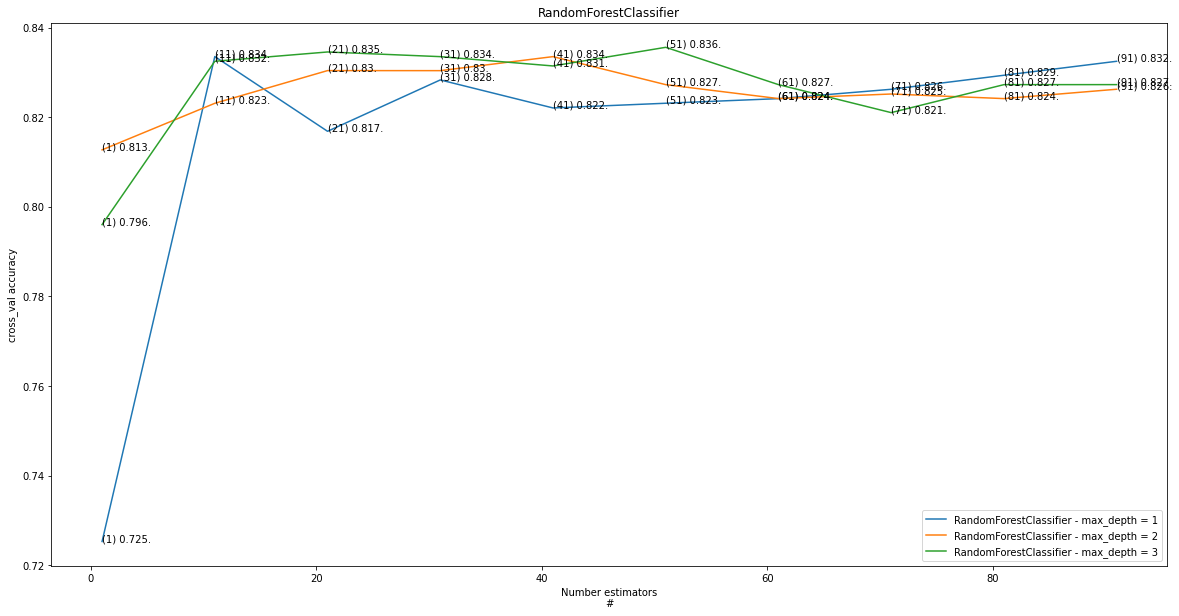

In [138]:
plt.figure(figsize=(20,10))
plt.plot(number_estimators, rf_scores_1, label="RandomForestClassifier - max_depth = 1")
for a,b in zip(number_estimators, rf_scores_1):
    plt.text(a, b, str("({}) {}.".format(a,round(b,3))))

plt.plot(number_estimators, rf_scores_2, label="RandomForestClassifier - max_depth = 2")
for a,b in zip(number_estimators, rf_scores_2):
    plt.text(a, b, str("({}) {}.".format(a,round(b,3))))

plt.plot(number_estimators, rf_scores_3, label="RandomForestClassifier - max_depth = 3")
for a,b in zip(number_estimators, rf_scores_3):
    plt.text(a, b, str("({}) {}.".format(a,round(b,3))))

plt.xlabel('Number estimators\n#')
plt.ylabel('cross_val accuracy')
plt.title('RandomForestClassifier')
plt.legend()
plt.savefig("figures_python/parameters/rfc_graph.pdf")
plt.show()

## Tabla de error

In [139]:
y_true, y_pred = y_test, best_rfc.predict(X_test)
report = classification_report(y_true, y_pred, output_dict=True)
print("RandomForestClassifier GridSearch best estimator: ",accuracy_score(y_test, y_pred, normalize = True))

RandomForestClassifier GridSearch best estimator:  0.8378378378378378


In [140]:
df = pd.DataFrame(report).transpose()
# Export to latex
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &     support \\
\midrule
0            &   0.849057 &  0.855513 &  0.852273 &  263.000000 \\
1            &   0.824074 &  0.816514 &  0.820276 &  218.000000 \\
accuracy     &   0.837838 &  0.837838 &  0.837838 &    0.837838 \\
macro avg    &   0.836565 &  0.836014 &  0.836275 &  481.000000 \\
weighted avg &   0.837734 &  0.837838 &  0.837771 &  481.000000 \\
\bottomrule
\end{tabular}



In [141]:
m = confusion_matrix(y_test, y_pred)
print(m)
total = m.sum()
print("Verdadero Positivos:", m[0,0]/total)
print("Falsos Positivos:", m[0,1]/total)
print("Verdadero Negativos:", m[1,1]/total)
print("Falsos Negativos:", m[1,0]/total)
ratio = (m[0,0]+m[1,1])/total
print("Acccuracy:", ratio)

[[225  38]
 [ 40 178]]
Verdadero Positivos: 0.4677754677754678
Falsos Positivos: 0.079002079002079
Verdadero Negativos: 0.3700623700623701
Falsos Negativos: 0.08316008316008316
Acccuracy: 0.8378378378378378


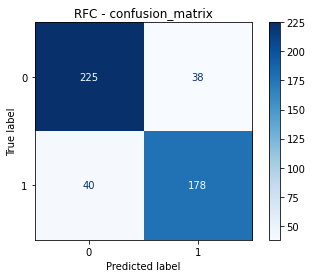

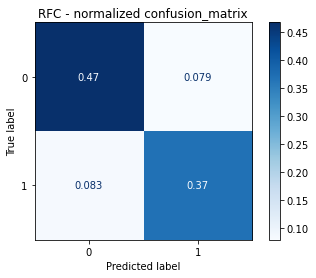

In [142]:
# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(best_rfc, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title("RFC - confusion_matrix")

plt.savefig("figures_python/confusion_matrix/rfc.pdf")
plt.show()

disp = plot_confusion_matrix(best_rfc, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='all')
disp.ax_.set_title("RFC - normalized confusion_matrix")

plt.savefig("figures_python/confusion_matrix/rfc_normalized.pdf")
plt.show()

## ROC

In [143]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=N_SPLITS)

tprs_rfc = []
aucs_rfc = []
mean_fpr_rfc = np.linspace(0, 1, 100)

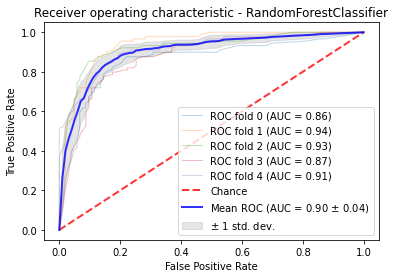

In [144]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    best_rfc.fit(X.iloc[train], y.iloc[train])
    viz = plot_roc_curve(best_rfc, X.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr_rfc, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs_rfc.append(interp_tpr)
    aucs_rfc.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr_rfc = np.mean(tprs_rfc, axis=0)
mean_tpr_rfc[-1] = 1.0
mean_auc_rfc= auc(mean_fpr_rfc, mean_tpr_rfc)
std_auc_rfc = np.std(aucs_svc)
ax.plot(mean_fpr_rfc, mean_tpr_rfc, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_rfc, std_auc_rfc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs_rfc, axis=0)
tprs_upper = np.minimum(mean_tpr_rfc + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_rfc - std_tpr, 0)
ax.fill_between(mean_fpr_rfc, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic - RandomForestClassifier")
ax.legend(loc="lower right")
plt.savefig("figures_python/roc/rfc.pdf")
plt.show()

## Validation Curve

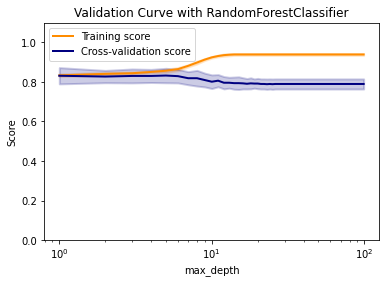

In [145]:
param_range=np.arange(1, 100)

train_scores, test_scores = validation_curve(best_rfc, X, y, param_name="clf__max_depth", param_range=param_range, scoring="accuracy", cv=N_SPLITS)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with RandomForestClassifier")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.savefig("figures_python/validation_curves/rfc.pdf")
plt.show()

## Learning Curve

In [146]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores, fit_times, _ = \
    learning_curve(best_rfc, X, y, cv=N_SPLITS, scoring='accuracy', train_sizes=np.linspace(.1, 1.0, 5), return_times=True)

# Create means and standard deviations of training set scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
# Create means and standard deviations of test set scores
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

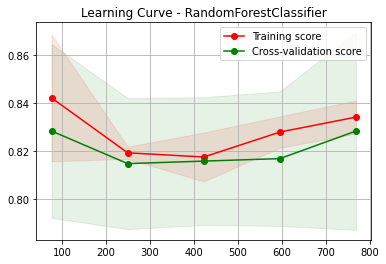

In [147]:
# Learning curve
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1,
                        color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                label="Cross-validation score")
plt.title("Learning Curve - RandomForestClassifier")
plt.legend(loc="best")
plt.savefig("figures_python/learning_curves/rfc.pdf")
plt.show()

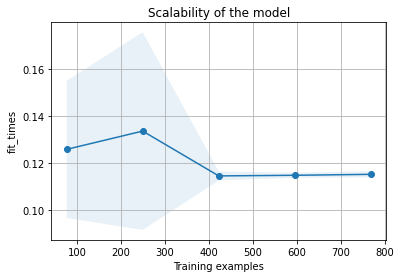

In [148]:
# Plot n_samples vs fit_times
plt.grid()
plt.plot(train_sizes, fit_times_mean, 'o-')
plt.fill_between(train_sizes, fit_times_mean - fit_times_std,
                        fit_times_mean + fit_times_std, alpha=0.1)
plt.xlabel("Training examples")
plt.ylabel("fit_times")
plt.title("Scalability of the model")
plt.savefig("figures_python/learning_curves/rfc_scalability.pdf")
plt.show()

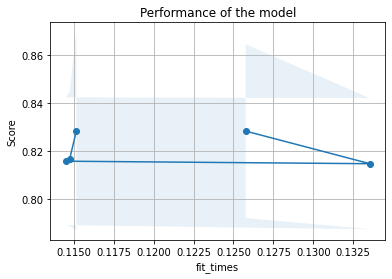

In [149]:
# Plot fit_time vs score
plt.grid()
plt.plot(fit_times_mean, test_scores_mean, 'o-')
plt.fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1)
plt.xlabel("fit_times")
plt.ylabel("Score")
plt.title("Performance of the model")
plt.savefig("figures_python/learning_curves/rfc_performance.pdf")
plt.show()

# Comparison

LR: 0.833528 (0.032320)
KNN: 0.817913 (0.026234)
SVC: 0.828325 (0.038871)
GBC: 0.785627 (0.037102)
RFC: 0.831439 (0.041161)


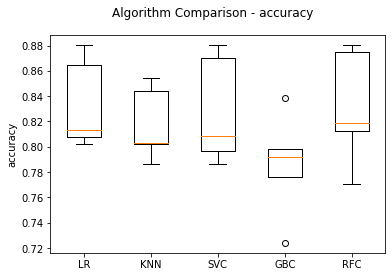

In [161]:
# prepare models
models = []
models.append(('LR', best_lr))
models.append(('KNN', best_knn))
models.append(('SVC', best_svc))
models.append(('GBC', best_gbc))
models.append(('RFC', best_rfc))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
	cv_results = cross_val_score(model, X, y, cv=N_SPLITS, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison - ' + scoring)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_ylabel(scoring)
ax.set_xticklabels(names)
plt.savefig("figures_python/comparison/accuracy.pdf")
plt.show()

LR: 0.819461 (0.041022)
KNN: 0.792745 (0.042744)
SVC: 0.807295 (0.053574)
GBC: 0.723419 (0.080951)
RFC: 0.799719 (0.069714)


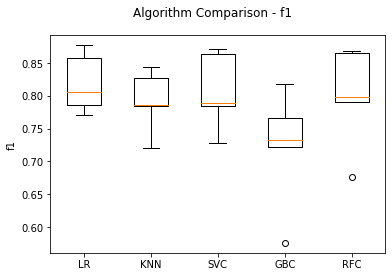

In [160]:
# prepare models
models = []
models.append(('LR', best_lr))
models.append(('KNN', best_knn))
models.append(('SVC', best_svc))
models.append(('GBC', best_gbc))
models.append(('RFC', best_rfc))

# evaluate each model in turn
results = []
names = []
scoring = 'f1'

for name, model in models:
	cv_results = cross_val_score(model, X, y, cv=N_SPLITS, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison - ' + scoring)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_ylabel(scoring)
ax.set_xticklabels(names)
plt.savefig("figures_python/comparison/f1.pdf")
plt.show()

LR: 0.824719 (0.077715)
KNN: 0.764045 (0.088472)
SVC: 0.791011 (0.096812)
GBC: 0.631461 (0.129170)
RFC: 0.755056 (0.125803)


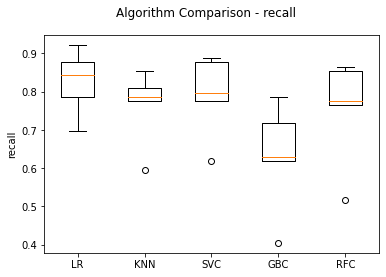

In [162]:
# prepare models
models = []
models.append(('LR', best_lr))
models.append(('KNN', best_knn))
models.append(('SVC', best_svc))
models.append(('GBC', best_gbc))
models.append(('RFC', best_rfc))

# evaluate each model in turn
results = []
names = []
scoring = 'recall'

for name, model in models:
	cv_results = cross_val_score(model, X, y, cv=N_SPLITS, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison - ' + scoring)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_ylabel(scoring)
ax.set_xticklabels(names)
plt.savefig("figures_python/comparison/recall.pdf")
plt.show()

LR: 0.819254 (0.033554)
KNN: 0.835127 (0.045738)
SVC: 0.833651 (0.041968)
GBC: 0.884859 (0.063208)
RFC: 0.873664 (0.058133)


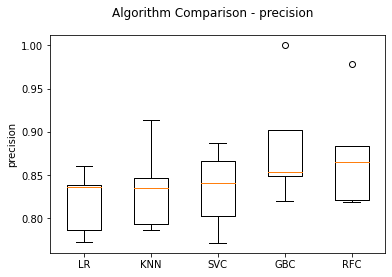

In [163]:
# prepare models
models = []
models.append(('LR', best_lr))
models.append(('KNN', best_knn))
models.append(('SVC', best_svc))
models.append(('GBC', best_gbc))
models.append(('RFC', best_rfc))

# evaluate each model in turn
results = []
names = []
scoring = 'precision'

for name, model in models:
	cv_results = cross_val_score(model, X, y, cv=N_SPLITS, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison - ' + scoring)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_ylabel(scoring)
ax.set_xticklabels(names)
plt.savefig("figures_python/comparison/precision.pdf")
plt.show()

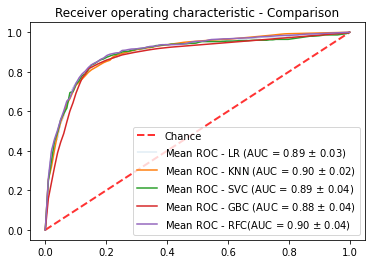

In [173]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

ax.plot(mean_fpr_lr, mean_tpr_lr, 
        label=r'Mean ROC - LR (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_lr, std_auc_lr),linewidth=0.5)

ax.plot(mean_fpr_knn, mean_tpr_knn, 
        label=r'Mean ROC - KNN (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_knn, std_auc_knn), linewidth=0.5)

ax.plot(mean_fpr_svc, mean_tpr_svc, 
        label=r'Mean ROC - SVC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_svc, std_auc_svc), linewidth=0.5)

ax.plot(mean_fpr_gbc, mean_tpr_gbc, 
        label=r'Mean ROC - GBC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_gbc, std_auc_gbc), linewidth=0.5)

ax.plot(mean_fpr_rfc, mean_tpr_rfc, 
        label=r'Mean ROC - RFC(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_rfc, std_auc_rfc), linewidth=0.5)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic - Comparison")
ax.legend(loc="lower right")
plt.savefig("figures_python/comparison/roc.pdf")
plt.show()